In [ ]:
from google.colab import files
import zipfile
import os

# Upload ZIP file
uploaded = files.upload()

# Assuming your ZIP filename (change if different)
zip_path = list(uploaded.keys())[0]  # automatically get uploaded filename
extract_path = "/content/dataset"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)
print(os.listdir(extract_path))


Saving archive (1).zip to archive (1).zip
Dataset extracted to: /content/dataset
['covid_update']


In [ ]:
# Paths for train and test folders
train_dir = os.path.join(extract_path, "covid_update/Train")
test_dir = os.path.join(extract_path, "covid_update/Test")

# Imports
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 453 images belonging to 2 classes.
Found 219 images belonging to 2 classes.


In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.906), 1: np.float64(1.1157635467980296)}


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model initially
for layer in base_model.layers:
    layer.trainable = False

# Custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)  # 2 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4464 - loss: 1.3527 - val_accuracy: 0.3881 - val_loss: 0.9770
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 746ms/step - accuracy: 0.4841 - loss: 1.0712 - val_accuracy: 0.3653 - val_loss: 0.8577
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 737ms/step - accuracy: 0.5422 - loss: 0.9178 - val_accuracy: 0.4612 - val_loss: 0.8106
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 735ms/step - accuracy: 0.4989 - loss: 0.9281 - val_accuracy: 0.4840 - val_loss: 0.7757
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 687ms/step - accuracy: 0.5181 - loss: 0.8873 - val_accuracy: 0.5068 - val_loss: 0.7411
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 720ms/step - accuracy: 0.5849 - loss: 0.7890 - val_accuracy: 0.5479 - val_loss: 0.7104
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 741ms/step - accuracy: 0.5710 - loss: 0.7675 - val_accuracy: 0.5799 - val_loss: 0.6831
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 740ms/step - accuracy: 0.6397 - loss: 0.7391 - val_accurac

In [ ]:
# Unfreeze last 50 layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7399 - loss: 0.5489 - val_accuracy: 0.7763 - val_loss: 0.4786
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 870ms/step - accuracy: 0.7902 - loss: 0.4630 - val_accuracy: 0.8265 - val_loss: 0.4375
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 765ms/step - accuracy: 0.8365 - loss: 0.3636 - val_accuracy: 0.8356 - val_loss: 0.4051
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 747ms/step - accuracy: 0.9059 - loss: 0.2666 - val_accuracy: 0.8493 - val_loss: 0.3798
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 871ms/step - accuracy: 0.9009 - loss: 0.2427 - val_accuracy: 0.8630 - val_loss: 0.3618
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 746ms/step - accuracy: 0.9401 - loss: 0.2077 - val_accuracy: 0.8584 - val_loss: 0.3534
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 714ms/step - accuracy: 0.9490 - loss: 0.1558 - val_accuracy: 0.8493 - val_loss: 0.3470
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 746ms/step - accuracy: 0.9510 - loss: 0.1514 - val_accurac

In [ ]:
loss, acc = model.evaluate(test_data)
print(f"\n✅ MobileNetV2 Final Test Accuracy: {acc * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 483ms/step - accuracy: 0.8820 - loss: 0.2824

✅ MobileNetV2 Final Test Accuracy: 84.93%


In [ ]:
import numpy as np

# Get true labels
y_true = test_data.classes  # Ground truth labels as integers

# Predict probabilities
y_pred_prob = model.predict(test_data)

# Predicted class labels from probabilities
y_pred = np.argmax(y_pred_prob, axis=1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 749ms/step


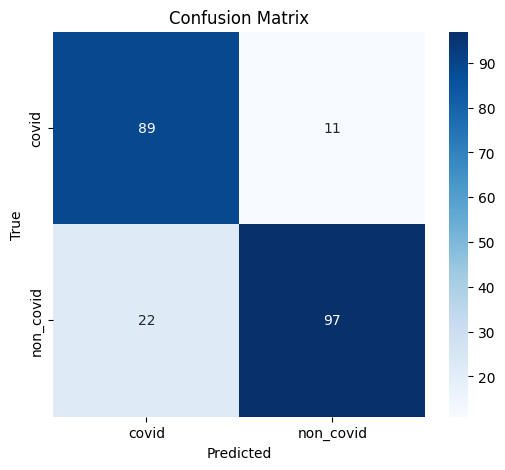

Classification Report:
               precision    recall  f1-score   support

       covid       0.80      0.89      0.84       100
   non_covid       0.90      0.82      0.85       119

    accuracy                           0.85       219
   macro avg       0.85      0.85      0.85       219
weighted avg       0.85      0.85      0.85       219



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=list(test_data.class_indices.keys()))
print("Classification Report:\n", report)


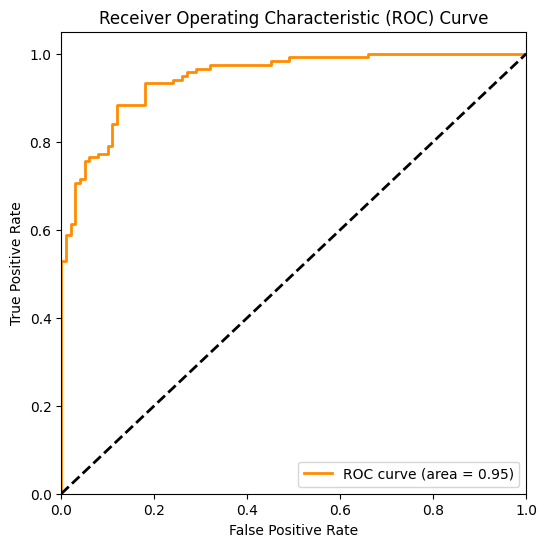

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True binary labels (0 or 1)
y_true_binary = y_true

# Probability of positive class (assuming class 1 is positive)
y_scores = y_pred_prob[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_binary, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Accuracy  : {accuracy * 100:.2f}%")
print(f"Precision : {precision * 100:.2f}%")
print(f"Recall    : {recall * 100:.2f}%")
print(f"F1 Score  : {f1 * 100:.2f}%")


Accuracy  : 84.93%
Precision : 89.81%
Recall    : 81.51%
F1 Score  : 85.46%


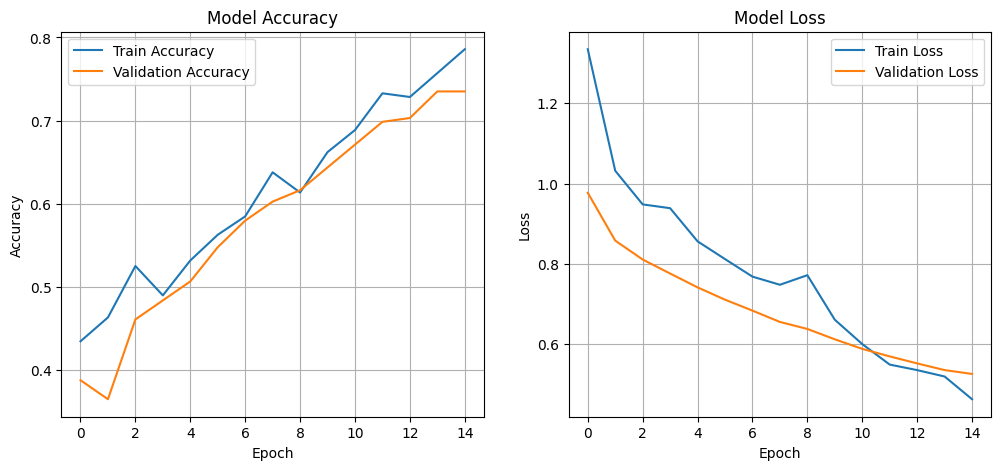

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


Saving yes covid.jpg to yes covid.jpg
User uploaded file: yes covid.jpg


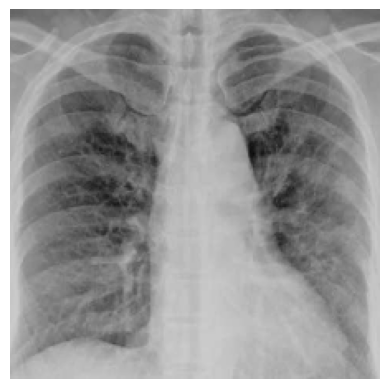

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: covid with confidence 0.92


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# Step 1: Upload image
uploaded = files.upload()

for img_name in uploaded.keys():
    print(f"User uploaded file: {img_name}")

    # Step 2: Load image
    img_path = img_name
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust size if needed

    # Step 3: Preprocess image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize, matching training preprocessing

    # Optional: Display image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Step 4: Predict
    preds = model.predict(img_array)

    # If binary classification with softmax or sigmoid
    if preds.shape[1] == 1:
        pred_class = 'Class 1' if preds[0][0] > 0.5 else 'Class 0'
        confidence = preds[0][0] if preds[0][0] > 0.5 else 1 - preds[0][0]
    else:
        pred_index = np.argmax(preds[0])
        class_labels = list(train_data.class_indices.keys())
        pred_class = class_labels[pred_index]
        confidence = preds[0][pred_index]

    print(f"Prediction: {pred_class} with confidence {confidence:.2f}")


In [ ]:
model.save("mobilenetv2_covid_model.h5")
print("✅ Model saved as 'mobilenetv2_covid_model.h5'")


✅ Model saved as 'mobilenetv2_covid_model.h5'


In [ ]:
from google.colab import files
files.download("mobilenetv2_covid_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>